# Full tutorial

In this tutorial, we want to demonstrate the full workflow of shnitsel tools from import to final analysis and output. 
Due to size constraints in git, we will use an already compressed shnitsel-file input for Retinal as a basis.
Please refer to the `./0_general_io` tutorial notebook for information on how to read arbitrary input.


In [1]:
import pandas as pd
import seaborn as sns

import shnitsel as st
import shnitsel.xarray


## 1) Import and preparation of data
### 1.1) Loading data

We use the generic `st.io.read()` function to import an existing shnitsel-tools file. 
Here, we could in principle also read from a collection of trajectories produced by one of the supported import formats: `NewtonX`, `SHARC`, `PyRAI2md` or `ASE`.

In [2]:
dt = st.io.read('./test_data/shnitsel/traj_I02.nc')
dt

<class 'shnitsel.data.tree.tree.ShnitselDBRoot[Trajectory]'> [{'level': 'ShnitselDBRoot', 'children': '1: {\'I02\': \'ABCMeta(_name=\\\'I02\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=None, _children={\\\'0\\\': ABCMeta(_name=\\\'0\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=Trajectory(_raw_dataset=<xarray.Dataset> Size: 339kB\\nDimensions:              (time: 384, state: 3, atom: 14, direction: 3,\\n                          statecomb: 3, full_statecomb: 6)\\nCoordinates: (12/21)\\n  * time                 (time) float64 3kB 0.0 0.5 1.0 ... 190.5 191.0 191.5\\n  * state                (state) int64 24B 1 2 3\\n  * atom                 (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13\\n  * direction            (direction) <U1 12B \\\'x\\\' \\\'y\\\' \\\'z\\\'\\n  * statecomb            (statecomb) object 24B MultiIndex\\n  * full_statecomb       (full_statecomb) object 48B MultiIndex\\n    ...                   ...\\n  * full_statecomb_from  (full_statecomb) int64 48B 1 1 2 2 3 3\\n  * full_statecomb_to    (full_statecomb) int64 48B 2 3 1 3 1 2\\n    delta_t              float64 8B 0.5\\n    max_ts               int64 8B 384\\n    t_max                float64 8B 1e+03\\n    charge               float64 8B 1.0\\nData variables:\\n    energy               (time, state) float32 5kB ...\\n    forces               (time, state, atom, direction) float32 194kB ...\\n    atXYZ                (time, atom, direction) float32 65kB ...\\n    dip_perm             (time, state, direction) float32 14kB ...\\n    dip_trans            (time, statecomb, direction) float32 14kB ...\\n    socs                 (time, full_statecomb) complex128 37kB ...\\n    phases               (time, state) float32 5kB ...\\nAttributes: (12/17)\\n    input_format:           sharc\\n    t_max:                  1000.0\\n    delta_t:                0.5\\n    max_ts:                 384\\n    completed:              False\\n    input_type:             dynamic\\n    ...                     ...\\n    misc_input_settings:    {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"...\\n    trajectory_input_path:  retinal_tutorial/I02/TRAJ_00001\\n    trajid:                 1\\n    DataTree_Level:         TrajectoryData\\n    trajectory_id:          689768943\\n    __mol:                  <rdkit.Chem.rdchem.Mol object at 0x710aca05e6b0>, _is_multi_trajectory=False), _children={}, _attrs={\\\'input_format\\\': \\\'sharc\\\', \\\'t_max\\\': 1000.0, \\\'delta_t\\\': 0.5, \\\'max_ts\\\': 384, \\\'completed\\\': False, \\\'input_type\\\': \\\'dynamic\\\', \\\'input_format_version\\\': \\\'3.0\\\', \\\'num_singlets\\\': 3, \\\'num_doublets\\\': 0, \\\'num_triplets\\\': 0, \\\'has_forces\\\': True, \\\'misc_input_settings\\\': {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"\\\', \\\'veloc\\\': \\\'external\\\', \\\'velocfile\\\': \\\'"veloc"\\\', \\\'nstates\\\': [3], \\\'actstates\\\': \\\'3\\\', \\\'state\\\': \\\'2 mch\\\', \\\'coeff\\\': \\\'auto\\\', \\\'rngseed\\\': \\\'5199\\\', \\\'ezero\\\': \\\'-248.2781283000\\\', \\\'tmax\\\': \\\'1000.000000\\\', \\\'stepsize\\\': \\\'0.500000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'integrator\\\': \\\'fvv\\\', \\\'method\\\': \\\'tsh\\\', \\\'surf\\\': \\\'diagonal\\\', \\\'coupling\\\': \\\'overlap\\\', \\\'nogradcorrect\\\': True, \\\'ekincorrect\\\': \\\'parallel_vel\\\', \\\'reflect_frustrated\\\': \\\'none\\\', \\\'decoherence_scheme\\\': \\\'edc\\\', \\\'decoherence_param\\\': \\\'0.1\\\', \\\'hopping_procedure\\\': \\\'sharc\\\', \\\'grad_all\\\': True, \\\'eselect\\\': \\\'0.001000\\\', \\\'select_directly\\\': True, \\\'nospinorbit\\\': True, \\\'write_grad\\\': True, \\\'write_nacdr\\\': True, \\\'write_overlap\\\': True, \\\'output_format\\\': \\\'ascii\\\', \\\'output_dat_steps\\\': \\\'1\\\'}, \\\'output.dat\\\': {\\\'SHARC_version\\\': \\\'3.0\\\', \\\'method\\\': \\\'0\\\', 

### 1.2) Cleaning data

To make sure that we exclude numerical artifacts and only consider physically relevant configurations, the `st.io.clean` module offers the `sanity_check()` function to support the filtering of input data. 
Configuration options are available via the various configuration parameters. 
By default, `sanity_check()` peforms both energy- and bond-length filtration. If you only wish to apply either of those, you can use split functions directly, specifically `filter_by_energy()` and `filter_by_length()` also found in the `st.io.clean` module.

Multiple ways to deal with physically irrelevant data are supported:
- `omit`: This method gets rid of all trajectories that violate the constraints at any point
- `truncate`: This method cuts off all trajectories at the first frame where they would violate the configured constraints
- `transect` (indicated by a float representing the desired `time` at which to cut off): This method omits all trajectories that violate the constraints before the specified time and cuts all other trajectories off at the configured time. 

In [3]:
from shnitsel.clean import sanity_check
# 'Truncate': Cut off at first violation 
truncated_dt = sanity_check(dt, 'truncate')
# 'Transect': Cut off if configured time is reached, else omit. Note that the time value is in units of the time dimension of the dataset.
# transected_dt = sanity_check(dt, 20.0)
truncated_dt

<class 'shnitsel.data.tree.tree.ShnitselDBRoot[Trajectory]'> [{'level': 'ShnitselDBRoot', 'children': '1: {\'I02\': \'ABCMeta(_name=\\\'I02\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=None, _children={\\\'0\\\': ABCMeta(_name=\\\'0\\\', _dtype=<class \\\'shnitsel.data.dataset_containers.trajectory.Trajectory\\\'>, _data=Trajectory(_raw_dataset=<xarray.Dataset> Size: 343kB\\nDimensions:              (time: 382, state: 3, atom: 14, direction: 3,\\n                          statecomb: 3, full_statecomb: 6, energy_criterion: 2,\\n                          length_criterion: 2)\\nCoordinates: (12/25)\\n  * time                 (time) float64 3kB 0.0 0.5 1.0 ... 189.5 190.0 190.5\\n  * state                (state) int64 24B 1 2 3\\n  * atom                 (atom) int64 112B 0 1 2 3 4 5 6 7 8 9 10 11 12 13\\n  * direction            (direction) <U1 12B \\\'x\\\' \\\'y\\\' \\\'z\\\'\\n  * statecomb            (statecomb) object 24B MultiIndex\\n  * full_statecomb       (full_statecomb) object 48B MultiIndex\\n    ...                   ...\\n    delta_t              float64 8B 0.5\\n    max_ts               int64 8B 384\\n    t_max                float64 8B 1e+03\\n    charge               float64 8B 1.0\\n    energy_thresholds    (energy_criterion) float64 16B 0.7 1.0\\n    length_thresholds    (length_criterion) float64 16B 3.0 2.0\\nData variables:\\n    energy               (time, state) float32 5kB ...\\n    forces               (time, state, atom, direction) float32 193kB ...\\n    atXYZ                (time, atom, direction) float32 64kB -4.182 ... 3.616\\n    dip_perm             (time, state, direction) float32 14kB ...\\n    dip_trans            (time, statecomb, direction) float32 14kB ...\\n    socs                 (time, full_statecomb) complex128 37kB ...\\n    phases               (time, state) float32 5kB ...\\n    energy_filtranda     (energy_criterion, time) float32 3kB 0.0 0.1572 ... 0.0\\n    length_filtranda     (length_criterion, time) float32 3kB 1.455 ... 1.21\\nAttributes: (12/17)\\n    input_format:           sharc\\n    t_max:                  1000.0\\n    delta_t:                0.5\\n    max_ts:                 384\\n    completed:              False\\n    input_type:             dynamic\\n    ...                     ...\\n    misc_input_settings:    {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"...\\n    trajectory_input_path:  retinal_tutorial/I02/TRAJ_00001\\n    trajid:                 1\\n    DataTree_Level:         TrajectoryData\\n    trajectory_id:          689768943\\n    __mol:                  <rdkit.Chem.rdchem.Mol object at 0x710aca05e6b0>, _is_multi_trajectory=False), _children={}, _attrs={\\\'input_format\\\': \\\'sharc\\\', \\\'t_max\\\': 1000.0, \\\'delta_t\\\': 0.5, \\\'max_ts\\\': 384, \\\'completed\\\': False, \\\'input_type\\\': \\\'dynamic\\\', \\\'input_format_version\\\': \\\'3.0\\\', \\\'num_singlets\\\': 3, \\\'num_doublets\\\': 0, \\\'num_triplets\\\': 0, \\\'has_forces\\\': True, \\\'misc_input_settings\\\': {\\\'input\\\': {\\\'printlevel\\\': \\\'2\\\', \\\'geomfile\\\': \\\'"geom"\\\', \\\'veloc\\\': \\\'external\\\', \\\'velocfile\\\': \\\'"veloc"\\\', \\\'nstates\\\': [3], \\\'actstates\\\': \\\'3\\\', \\\'state\\\': \\\'2 mch\\\', \\\'coeff\\\': \\\'auto\\\', \\\'rngseed\\\': \\\'5199\\\', \\\'ezero\\\': \\\'-248.2781283000\\\', \\\'tmax\\\': \\\'1000.000000\\\', \\\'stepsize\\\': \\\'0.500000\\\', \\\'nsubsteps\\\': \\\'25\\\', \\\'integrator\\\': \\\'fvv\\\', \\\'method\\\': \\\'tsh\\\', \\\'surf\\\': \\\'diagonal\\\', \\\'coupling\\\': \\\'overlap\\\', \\\'nogradcorrect\\\': True, \\\'ekincorrect\\\': \\\'parallel_vel\\\', \\\'reflect_frustrated\\\': \\\'none\\\', \\\'decoherence_scheme\\\': \\\'edc\\\', \\\'decoherence_param\\\': \\\'0.1\\\', \\\'hopping_procedure\\\': \\\'sharc\\\', \\\'grad_all\\\': True, \\\'eselect\\\': \\\'0.001000\\\', \\\'select_directly\\\': True, \\\'nospinorbit\\\': Tru

## 1.2) Optional: Converting the data

For processing or analysis, you may prefer to work with a single `xarray.Dataset`.
Shnitsel tree formats support conversion to either a `stacked` (i.e. transformed into a series of frames) or `layered` format (i.e. a new coordinate `trajectory` to index the various trajectories along)
via two accessor properties:

In [4]:
# Get a `stacked` representation of the data in the tree
ds_stacked = truncated_dt.as_stacked
# Get a `layered` representation of the data in the tree
ds_layered = truncated_dt.as_layered

/home/tpadmin/git/shnitsel-tools-official/shnitsel/data/traj_combiner_methods.py:491: FutureWarning: In a future version of xarray the default value for compat will change from compat='equals' to compat='override'. This change will result in the following ValueError: Cannot specify both coords='different' and compat='override'. The recommendation is to set compat explicitly for this case.
  frames = xr.concat(
/home/tpadmin/git/shnitsel-tools-official/shnitsel/data/traj_combiner_methods.py:735: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  layers = xr.concat(


## 2) Selection of relevant states and geometrical features

### 2.1) Geometrical features

We may not wish to perform the analysis of principal components or other statistics on the full structure. 
For example, we may wish to restrict our analysis to a subset. 
`Shnitsel-tools` provides a rich module for the selection of these geometric features in `shnitsel.filtering`. 
The `StructureSelection` class helps with the control of relevant structures. 

First, you need to initialize the Structure selection:

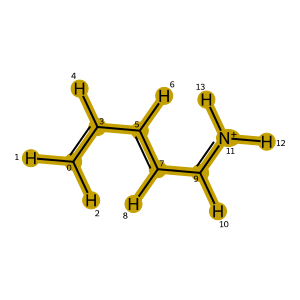

In [5]:
from shnitsel.filtering import StructureSelection

# Create a selection of all features 
structure_all = StructureSelection.init_from_dataset(ds_stacked, ['atoms', 'bonds', 'angles', 'dihedrals', 'pyramids'])

# Create a selection of only bond lengths and dihedrals
structure_bd = StructureSelection.init_from_dataset(ds_stacked, ['bonds', 'dihedrals'])
structure_bd.draw()

Generally, the initial selection includes all instances of the features in the array following the dataset. 
In the first case all features supported by the selection class.
In the second case only bond pairs and dihedrals. 

If you ever change your mind, you can add a specific feature back with the `.select_all()` method or (without a parameter) have all features activated on the selection:

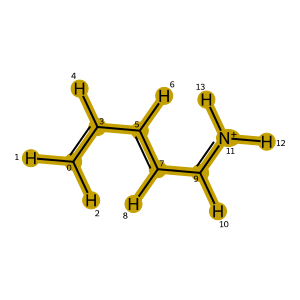

In [6]:
# Add `atoms`, i.e. positions back into the selection
structure_abd = structure_bd.select_all('atoms')
# Add all features back
structure_all2 = structure_bd.select_all()
structure_abd.draw()

You can select specific features either with tuples representing them or using `SMARTS` strings. 
Additionally, you have the option to select all BATS (positions, bonds, angles, torsions and pyramidalization centers) at the same time with `.select()` (or `.select_bats()`) or modify the selection of individual features using `.select_atoms()`, `.select_bonds()`, `.select_angles()`, `.select_dihedrals()`, and `.select_pyramids()` respectively.

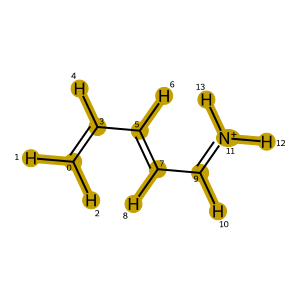

In [7]:
# Select all bonds from a C or N atom to an H atom
structure_all.select_bonds('[#6,#7]~[#1]').draw()

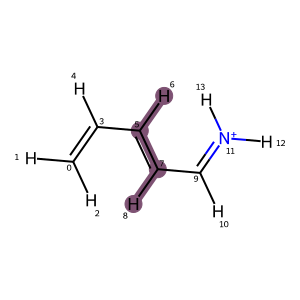

In [8]:
# Pick one specific dihedral:
structure_all.select_dihedrals((6,5,7,8)).draw('dihedrals')

You can combine multiple selections via simple set operations, i.e. 
- `+` or `|` to add two selections together 
- `-` to remove the second selection from the first
- `&` to obtain the intersection between two selections
- `~` to obtain an inverted selection.

For example, if we want to select the two central dihedrals in retinal to calculate HOOP (hydrogen out of plane):

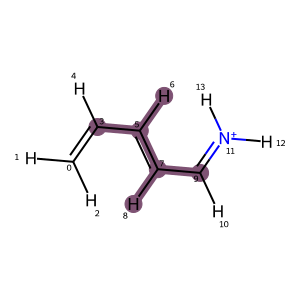

In [9]:
# Only keep the selection of dihedrals 
dih_6578 = structure_all.select_dihedrals((6,5,7,8)).only('dihedrals')
dih_CCCC = structure_all.select_dihedrals("[#6][#6]=[#6][#6]").only('dihedrals')

combined = dih_6578 | dih_CCCC
combined.draw('dihedrals')

We will now also present a quite visually pleasing way of combining our selection capabilities with the tools to calculate certain derived observables like distances
and use that to verify that our filtering was successful. 

E.g, our `sanity_check()` by default enforces a C-H bondlength of at most 2 angstroms. 
Let us get an overview of C-H bond lengths in the system:

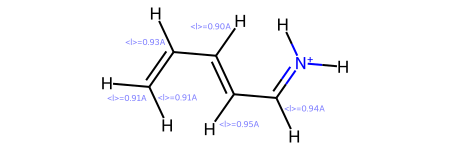

In [10]:
import rdkit
from shnitsel.geo.geocalc import get_distances
from rdkit.Chem import Mol
from shnitsel.bridges import default_mol
from shnitsel.units.conversion import convert_length

# Get all lengths of C-H bonds by creating an on-the-go structural selection using SMARTS strings directly
c_h_distances = get_distances(ds_stacked, structure_selection="[#6][#1]")

# Get a mol object for our dataset:
draw_mol = default_mol(ds_stacked)

# Calculate proportions per bond and annotate the molecule.
for bond_descriptor in c_h_distances.feature_indices.values:
    bond_index = structure_all.bond_descriptor_to_mol_index(
        bond_descriptor
    )
    dist = convert_length(c_h_distances.sel(feature_indices=bond_descriptor), "angstrom")
    
    # Assign the label to the bond
    draw_mol.GetBondWithIdx(bond_index).SetProp(
        'bondNote', f"<l>={dist.min().item():.2f}A"
    )
draw_mol

So on average our C-H bonds are around `0.9A` long. 
But let us check that all of them are below `2A`:

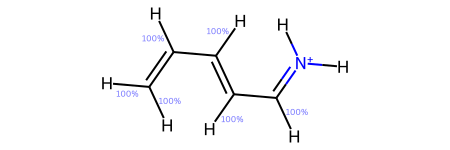

In [11]:
import rdkit
from shnitsel.geo.geocalc import get_distances
from rdkit.Chem import Mol
from shnitsel.bridges import default_mol
from shnitsel.units.conversion import convert_length

# Get all lengths of C-H bonds by creating an on-the-go structural selection using SMARTS strings directly
c_h_distances = get_distances(ds_stacked, structure_selection="[#6][#1]")

# Get a mol object for our dataset:
draw_mol = default_mol(ds_stacked)

# Calculate proportions per bond and annotate the molecule.
for bond_descriptor in c_h_distances.feature_indices.values:
    bond_index = structure_all.bond_descriptor_to_mol_index(
        bond_descriptor
    )
    dist = convert_length(c_h_distances.sel(feature_indices=bond_descriptor), "angstrom")

    # Get ratio of bonds below 2 A
    proportion =  ((dist < 2).sum() / dist.sizes['frame']).item()

    # Assign the label to the bond
    draw_mol.GetBondWithIdx(bond_index).SetProp(
        'bondNote', f"{proportion * 100:.0f}%"
    )
draw_mol

And indeed, all of our bonds are within the constraints, proving that our filtration has worked. 

## 3) Structural analysis

### 3.1) General Principal Component Analysis (PCA)

Shnitsel tools has extensive support for PCA analysis combined with the strong selection/filtration features presented above.
Let us demonstrate this on the example of retinal and try and identify the most significant contributing features of the retinal energy landscape.

First, we will perform a PCA to identify key features of the Retinal and investigate clustering behavior.
The following box demonstrates multiple options for doing so, using the `biplot_kde()` function that 
plots the PCA results, highlights clusters based on a KDE density estimation and plots the most relevant features of the PCAs
as visualizations on the molecular structure:

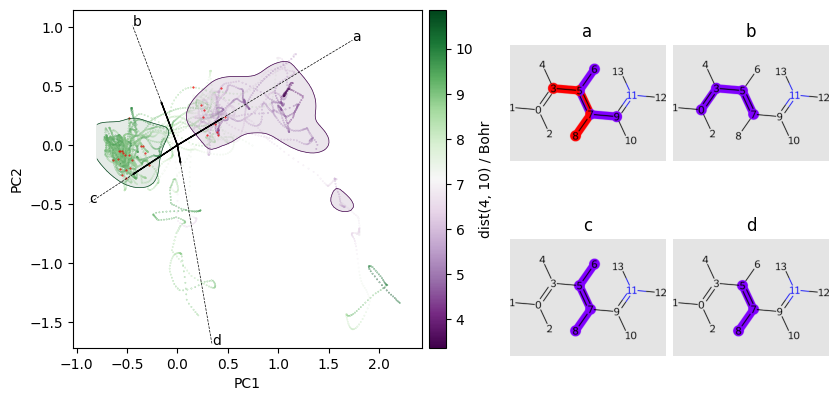

In [12]:
from shnitsel.analyze.pca import PCA
from shnitsel.vis.plot.kde import biplot_kde

# We can create the plot with a feature selection and make it calculate the PCA directly:
# biplot_kde(ds_stacked, 6,5,7,8, structure_selection=structure_all.only(['bonds', 'dihedrals', 'angles']), scatter_color_property='geo')

# Or we can calculate the PCA ourselves and provide it to the biplot function:
pca_res = PCA(ds_stacked, structure_selection=structure_all.only(['bonds', 'dihedrals', 'angles']))

# We can plot the PCA analysis with coloring using the `time` coordinate to see how trajectories evolve over time in PCA space:
# biplot_kde(ds_stacked, pca_data=pca_res, scatter_color_property='time')

# We can highlight the dihedral (6,5,7,8) as the coloring property to differentiate the different isomers
# biplot_kde(ds_stacked, 6,5,7,8, pca_data=pca_res, scatter_color_property='geo')

# Or we can use the distance between H atoms 4 and 10 as a coloring parameter to indicate isomerization 
# but then we may have to provide our own range for the clustering in `geo_kde_ranges` because default
# clustering ranges are for bond-lengths and 4-10 is not a true bond.
plot = biplot_kde(ds_stacked, 4, 10, pca_data=pca_res, scatter_color_property='geo', geo_kde_ranges=[(0,6), (8,15)])

We can see, that the molecule isomerizes based on the distance between the H-atoms with indices 4 and 10. 
However, the PCA result provides us with more in-depth results. 
From the Biplot figures a-d we can already see that the central dihedrals around C-C bond (5,7) are most relevant for the isomerization classification.

If we want to gain deeper insights into the most relevant features, we can retrieve a description of the PCA result in textual form:

In [13]:
# The parameters for `.explain_loadings(n1, n2)` are the number of most-weighted features per PCA component (n1) and overall across all components (n2)
print(pca_res.explain_loadings(5,5))

Maximum contributing features overall:
 dih(0,3,5,7) (weight: 0.4002896845340729) (Idxs: (0, 3, 5, 7)) 
 dih(3,5,7,9) (weight: 0.45366981625556946) (Idxs: (3, 5, 7, 9)) 
 dih(6,5,7,9) (weight: 0.4903942048549652) (Idxs: (6, 5, 7, 9)) 
 dih(3,5,7,8) (weight: 0.501832127571106) (Idxs: (3, 5, 7, 8)) 
 dih(6,5,7,8) (weight: 0.5060983896255493) (Idxs: (6, 5, 7, 8)) 


Maximum contributing features to component 0 :
 dih(8,7,9,10)  (weight: -0.16361398994922638) (Idxs: (8, 7, 9, 10)) 
 dih(3,5,7,9)  (weight: -0.41540634632110596) (Idxs: (3, 5, 7, 9)) 
 dih(3,5,7,8)  (weight: 0.44011834263801575) (Idxs: (3, 5, 7, 8)) 
 dih(6,5,7,8)  (weight: -0.44119080901145935) (Idxs: (6, 5, 7, 8)) 
 dih(6,5,7,9)  (weight: 0.4422222375869751) (Idxs: (6, 5, 7, 9)) 

Maximum contributing features to component 1 :
 dih(5,7,9,10)  (weight: -0.2583121359348297) (Idxs: (5, 7, 9, 10)) 
 dih(4,3,5,6)  (weight: 0.30467310547828674) (Idxs: (4, 3, 5, 6)) 
 dih(0,3,5,6)  (weight: -0.31193774938583374) (Idxs: (0, 3, 5, 6

This confirms our suspicion that, indeed, the first principal component has its highest contributions from all dihedrals surrounding the bond `5,7`.
Similarly, the second component has its most significant contributions from dihedrals around the bond `3,5`. 
This already tells us, that the isomerization around `5,7` is key to the structural and energetic landscape of the molecule. 
Similarly, the torsions around `3,5` provide degrees of freedom without a full isomerization of the molecule. 

## 3) Manual insights into structural features

From literature, one may realize, that the dihedrals in the center of the molecule around `(5,7)` are not only relevant as of themselves, but instead that their linear combinations, which describes the feature of `Hydrogen out of plane` (`HOOP`):

In [14]:
import numpy as np
from shnitsel.geo.geocalc_.dihedrals import dihedral
import xarray as xr

from shnitsel.geo.geocalc_.helpers import assign_descriptor_coords

# Calculate the dihedrals and the hoop measure
hoop = (dihedral(ds_stacked.positions, 6,5,7,8) - dihedral(ds_stacked.positions, 3,5,7,9))
hoop.name = "HOOP"
hoop

<xarray.DataArray 'HOOP' (frame: 4892)> Size: 20kB
array([ -1.1290894,  -2.127411 ,  -2.9948273, ..., -46.937065 ,
       -49.536137 , -52.037926 ], shape=(4892,), dtype=float32)
Coordinates:
  * frame        (frame) object 39kB MultiIndex
    astate       (frame) int32 20kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1
    sdiag        (frame) int32 20kB 2 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1 1
    charge       float64 8B 1.0
  * atrajectory  (frame) int64 39kB 1 1 1 1 1 1 1 1 ... 20 20 20 20 20 20 20 20
  * time         (frame) float64 39kB 0.0 0.5 1.0 1.5 ... 217.0 217.5 218.0
Attributes:
    units:    degrees

In addition, the so-called `Bond-Length-Alternation` (`BLA`) of the longest chromophor within the system might be important to quantify the energetic state of the molecule.
We can calculate the BLA as follows:

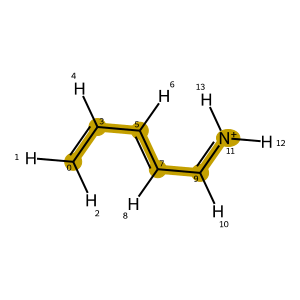

In [15]:
# First get the largest Chromophor selection:

bla_selection = structure_all.select_BLA_chromophor()
# Visualize the chomophor
bla_selection.draw()

In [16]:
from shnitsel.geo.geocalc import get_max_chromophor_BLA
# Now calculate the length of the chromophor BLA
chromophor_BLA = get_max_chromophor_BLA(ds_stacked, structure_selection=bla_selection)
chromophor_BLA

<xarray.DataArray 'BLA' (descriptor: 1, frame: 4892)> Size: 20kB
array([[0.10997677, 0.10950518, 0.10680151, ..., 0.12595081, 0.13470912,
        0.14393115]], shape=(1, 4892), dtype=float32)
Coordinates:
  * descriptor       (descriptor) <U3 12B 'BLA'
  * frame            (frame) object 39kB MultiIndex
    astate           (frame) int32 20kB 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    sdiag            (frame) int32 20kB 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    charge           float64 8B 1.0
  * atrajectory      (frame) int64 39kB 1 1 1 1 1 1 1 1 ... 20 20 20 20 20 20 20
  * time             (frame) float64 39kB 0.0 0.5 1.0 1.5 ... 217.0 217.5 218.0
    descriptor_tex   (descriptor) <U3 12B 'BLA'
  * descriptor_type  (descriptor) <U3 12B 'bla'
  * feature_indices  (descriptor) object 8B (1, -1)
Attributes:
    long_name:  Bond length alternation (BLA)
    unitdim:    length
    units:      Bohr

Let us now illustrate how we could create our own feature set to perform a PCA on including the `HOOP` and `BLA` as well as the distances angles within our selection:

In [17]:
from shnitsel.geo.geocalc import get_dihedrals, get_distances
import xarray as xr

# Get all interesting distances with an extensive SMARTS 
# (to illustrate the option to add multiple SMARTS)
distances = get_distances(ds_stacked,structure_selection=["[#1][#7]", "[#6]~[#6]"])

# Get the dihedrals just for good measure
# Use trigonometric values for better interplay with other parameters
# Use just the cosines of the result to avoid redundancy
dihedrals = get_dihedrals(ds_stacked,structure_selection=["[#6,#1]~[#6]~[#6,#7]~[#6,#7,#1]"], deg='trig').sel(descriptor_type='cos_dih')


# This part is only necessary to make the HOOP parameter a part of the manual PCA analysis.
# You do not need this to calculate the HOOP. It is metadata the PCA analysis uses for output.
if 'descriptor' not in hoop.dims:
  hoop = assign_descriptor_coords(
        hoop.expand_dims('descriptor'),
        feature_descriptors=[(6,5,7,8,3,5,7,9)],
        feature_type= ['hoop'],
        feature_tex_label=[r'hoop(5,7:6\to 8:3\to 9)'],
        feature_name=['hoop(6,5,7,8|3,5,7,9)'],
    )

# Merge the features set and let's have a look at it
feature_set = xr.concat([distances,dihedrals, chromophor_BLA, hoop], dim='descriptor')
feature_set
# dihedrals

<xarray.DataArray 'distances' (descriptor: 28, frame: 4892)> Size: 548kB
array([[  1.7274824 ,   1.7531409 ,   1.8007075 , ...,   2.0762656 ,
          2.0190077 ,   1.9528676 ],
       [  2.7055476 ,   2.6930227 ,   2.6798398 , ...,   2.8368409 ,
          2.8123899 ,   2.7849002 ],
       [  2.7028968 ,   2.7058063 ,   2.7092056 , ...,   2.910789  ,
          2.9275563 ,   2.942532  ],
       ...,
       [  0.9976716 ,   0.9971196 ,   0.99656   , ...,   0.9465555 ,
          0.9481291 ,   0.94996953],
       [  0.10997677,   0.10950518,   0.10680151, ...,   0.12595081,
          0.13470912,   0.14393115],
       [ -1.1290894 ,  -2.127411  ,  -2.9948273 , ..., -46.937065  ,
        -49.536137  , -52.037926  ]], shape=(28, 4892), dtype=float32)
Coordinates:
  * descriptor       (descriptor) <U21 2kB 'dist(11,13)' ... 'hoop(6,5,7,8|3,...
  * frame            (frame) object 39kB MultiIndex
    astate           (frame) int32 20kB 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    sdiag            (frame) int32 20kB 2 2 2 2 2 2 2 2 2 ... 1 1 1 1 1 1 1 1 1
    charge           float64 8B 1.0
  * atrajectory      (frame) int64 39kB 1 1 1 1 1 1 1 1 ... 20 20 20 20 20 20 20
  * time             (frame) float64 39kB 0.0 0.5 1.0 1.5 ... 217.0 217.5 218.0
    descriptor_tex   (descriptor) <U26 3kB '|\\vec{r}_{11,13}|' ... 'hoop(5,7...
  * descriptor_type  (descriptor) <U7 784B 'dist' 'dist' 'dist' ... 'bla' 'hoop'
  * feature_indices  (descriptor) object 224B (np.int64(11), np.int64(13)) .....
Attributes:
    long_name:  \|\mathbf{r}_{11,13}\|
    unitdim:    length
    units:      Bohr

Then perform the PCA on our custom set of descriptors

In [18]:
# Perform the PCA
pca_bla_hoop = PCA(feature_set, dim='descriptor')
# Get the explanation
print(pca_bla_hoop.explain_loadings())

Maximum contributing features overall:
 cos(0,3,5,7) (weight: 0.4035950303077698) (Idxs: (0, 3, 5, 7)) 
 cos(3,5,7,9) (weight: 0.45205700397491455) (Idxs: (3, 5, 7, 9)) 
 cos(6,5,7,9) (weight: 0.4942437708377838) (Idxs: (6, 5, 7, 9)) 
 cos(3,5,7,8) (weight: 0.5048153400421143) (Idxs: (3, 5, 7, 8)) 
 cos(6,5,7,8) (weight: 0.5229357481002808) (Idxs: (6, 5, 7, 8)) 


Maximum contributing features to component 0 :
 BLA  (weight: 0.13545674085617065) (Idxs: (1, -1)) 
 cos(3,5,7,9)  (weight: 0.4303325414657593) (Idxs: (3, 5, 7, 9)) 
 cos(6,5,7,9)  (weight: -0.45981672406196594) (Idxs: (6, 5, 7, 9)) 
 cos(3,5,7,8)  (weight: -0.4609215259552002) (Idxs: (3, 5, 7, 8)) 
 cos(6,5,7,8)  (weight: 0.46973347663879395) (Idxs: (6, 5, 7, 8)) 

Maximum contributing features to component 1 :
 cos(5,7,9,10)  (weight: -0.2794250249862671) (Idxs: (5, 7, 9, 10)) 
 cos(0,3,5,6)  (weight: -0.3450993001461029) (Idxs: (0, 3, 5, 6)) 
 cos(4,3,5,6)  (weight: 0.3489883244037628) (Idxs: (4, 3, 5, 6)) 
 cos(4,3,5,7)  

We see that the BLA made it into the top-5 contributing parameters of both components.
Additionally, the pca again identifies the angular constellation of bonds around the bond `5,7` as key.

Let us visualize the PCA result.

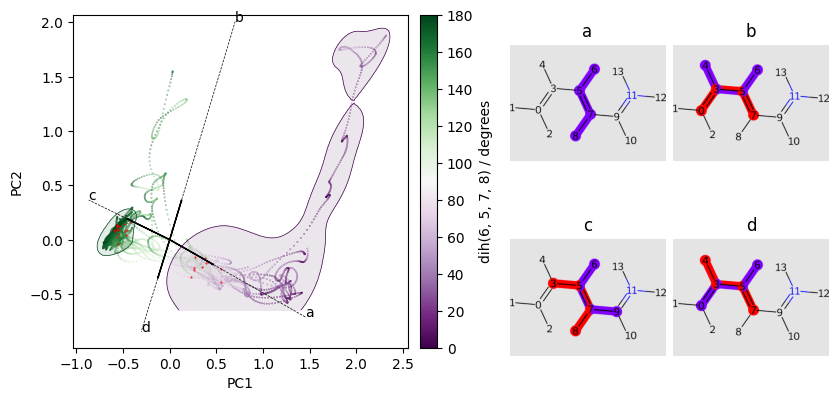

In [19]:
res = biplot_kde(ds_stacked, 6,5,7,8, pca_data=pca_bla_hoop, scatter_color_property='geo')

We see how the choice of descriptors as a basis for the PCA impacts the results, but nevertheless, the PCA still arrives at the same collection of most important individual parameters:
- The `PC1` first principal component entirely describes the angular constellation around bond `(5,7)`, but now it incorporates the `BLA` feature, which we previously did not consider, because individual distances did not contribute enough.
- The `PC2` component now (again) despite the very different parametrization focuses on the angular configuration around the bond `(3,5)` next to the central bond around which isomerization happens. It does not incorporate the BLA feature.

Overall, we can clearly see the two clusters of differently isomerized molecules around their central bond in the KDE plot above. 
As would be expected from classical PCA theory, the first principal component clearly parametrizes the transition between the two isomers.

## 4) Getting a general overview with the Datasheet

If there is no need for detailed analysis but instead, we want to get a quick overview of data within a dataset, `shnitsel-tools` offer a default visualization class, the `Datasheet` that provides a certain set of insights. 
For example, it can provide us with an overview of singlet-state statistics as well as triplet-state statistics, PCA-insights and general trajectory-level metadata. 

As a last point, we will here generate a datasheet for our filtered Retinal dataset:

/home/tpadmin/git/shnitsel-tools-official/shnitsel/data/traj_combiner_methods.py:491: FutureWarning: In a future version of xarray the default value for compat will change from compat='equals' to compat='override'. This change will result in the following ValueError: Cannot specify both coords='different' and compat='override'. The recommendation is to set compat explicitly for this case.
  frames = xr.concat(
Written: 100%|██████████| 1/1 [00:01<00:00,  2.00s/page]


{'/I02/agg/': [<Figure size 827x974.167 with 13 Axes>,
  <Figure size 150x150 with 9 Axes>,
  <Figure size 827x1169 with 7 Axes>]}

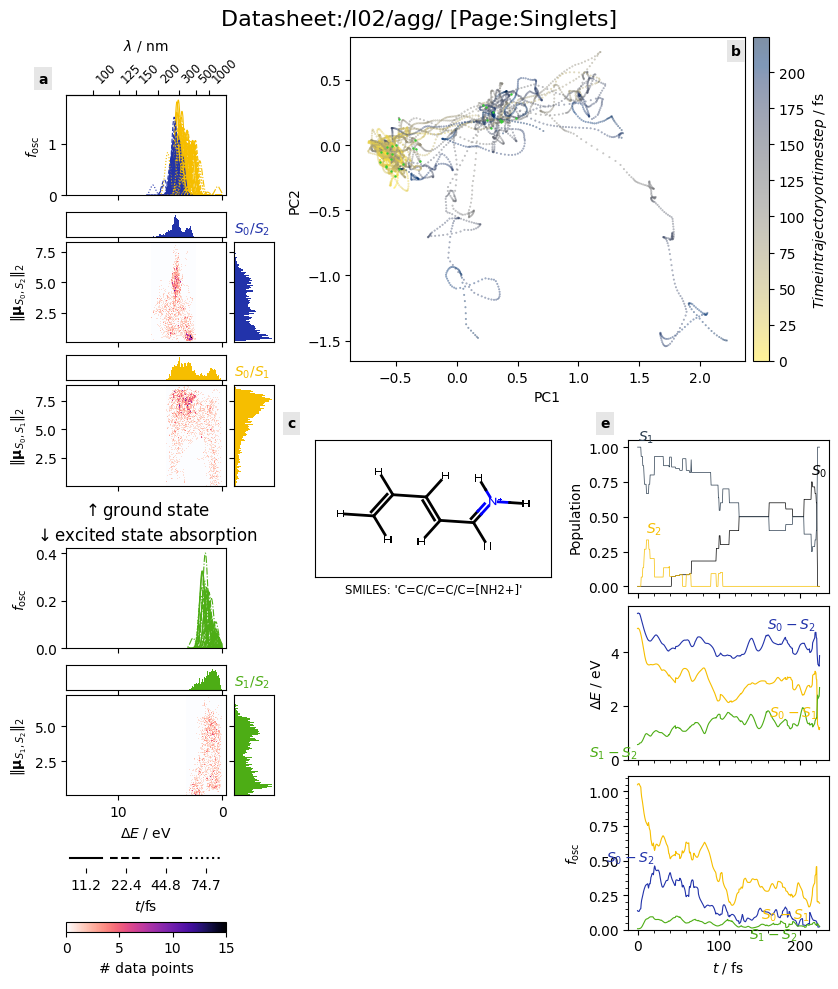

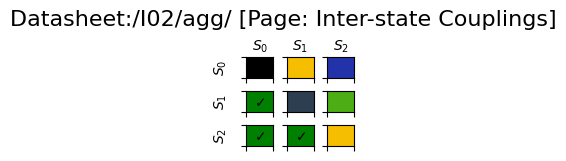

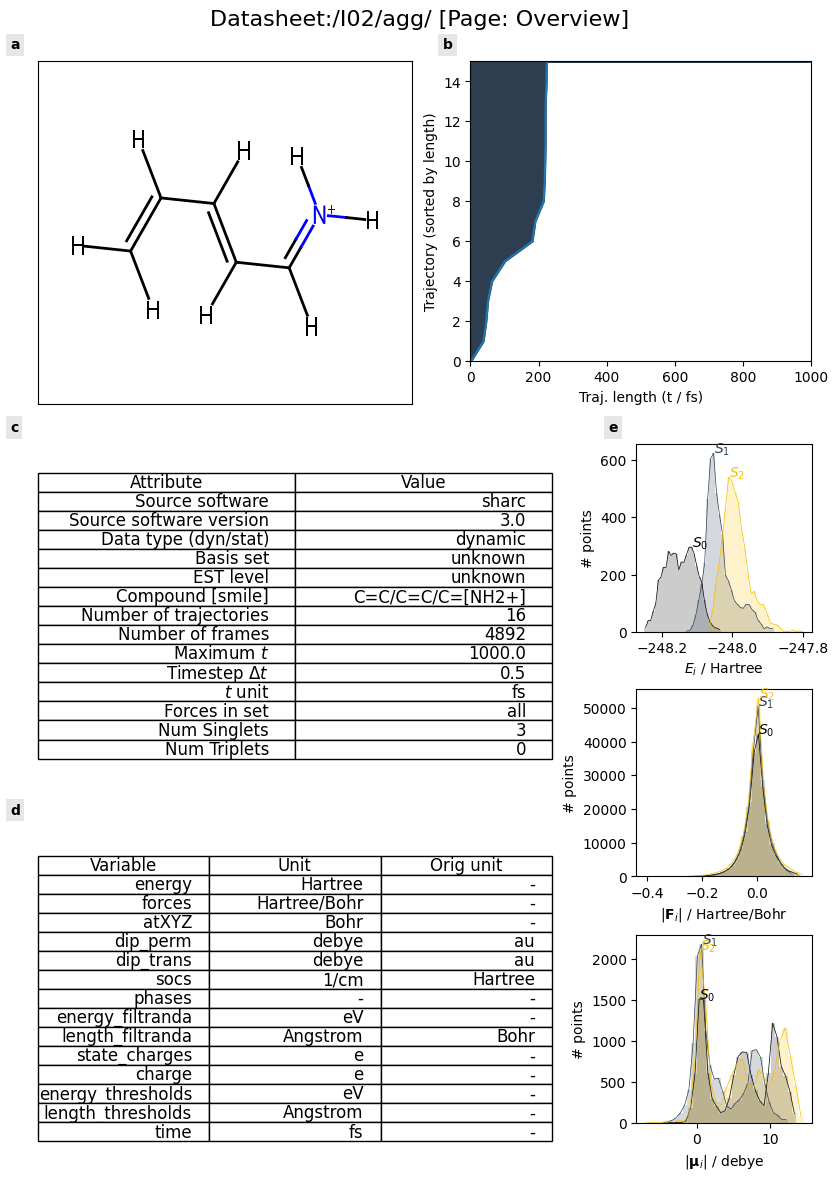

In [20]:
from shnitsel.vis.datasheet import Datasheet

# Initialize the datasheet structures
sheet = Datasheet(truncated_dt, 
                  structure_selection=structure_bd,
                  )

# To actually plot the datasheet, we can use the `plot()` command with which we can enable certain pages of the datasheet. 
# With the `path` parameter, the output can be written to a pdf. 
# Note, that this may take some time due to a wide range of analyses being run in parallel (can reach a few minutes depending on the dataset size)
sheet.plot(include_coupling_page=True, include_meta_page=True, path='./datasheet.pdf')


Of course we also have the option to pick and choose which states and combinations to include in the analysis, if we so choose:

/home/tpadmin/git/shnitsel-tools-official/shnitsel/data/traj_combiner_methods.py:491: FutureWarning: In a future version of xarray the default value for compat will change from compat='equals' to compat='override'. This change will result in the following ValueError: Cannot specify both coords='different' and compat='override'. The recommendation is to set compat explicitly for this case.
  frames = xr.concat(
Written: 100%|██████████| 1/1 [00:02<00:00,  2.36s/page]


{'/I02/agg/': [<Figure size 827x974.167 with 13 Axes>,
  <Figure size 827x974.167 with 13 Axes>,
  <Figure size 150x150 with 9 Axes>]}

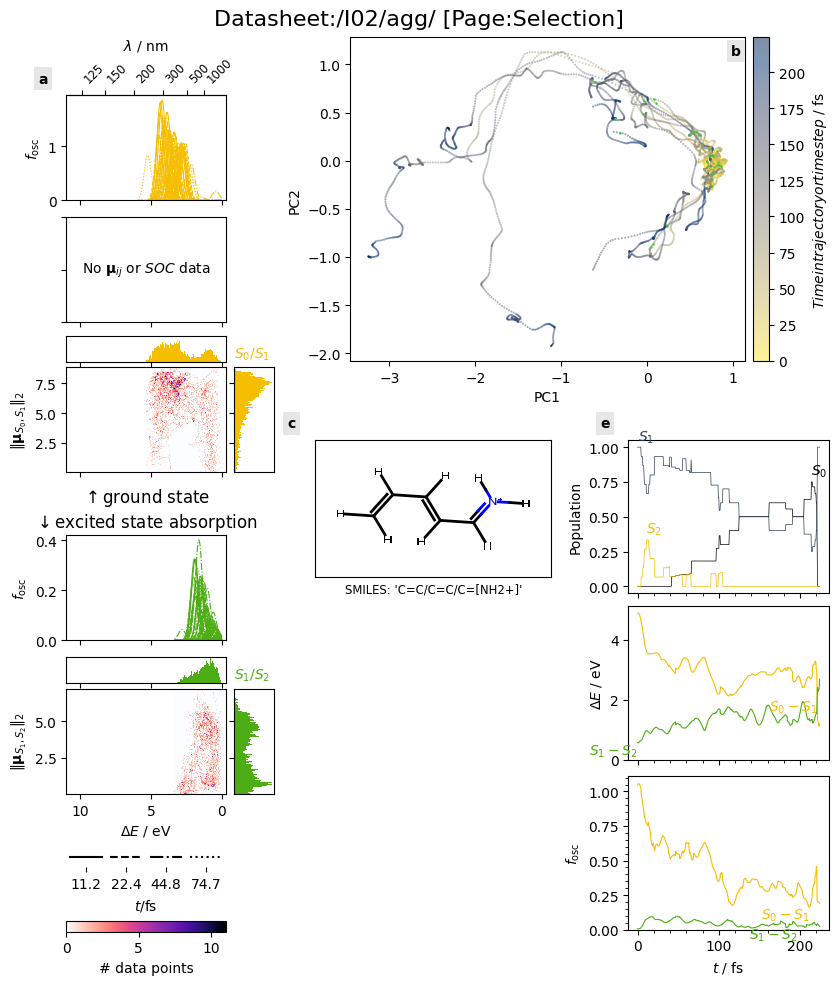

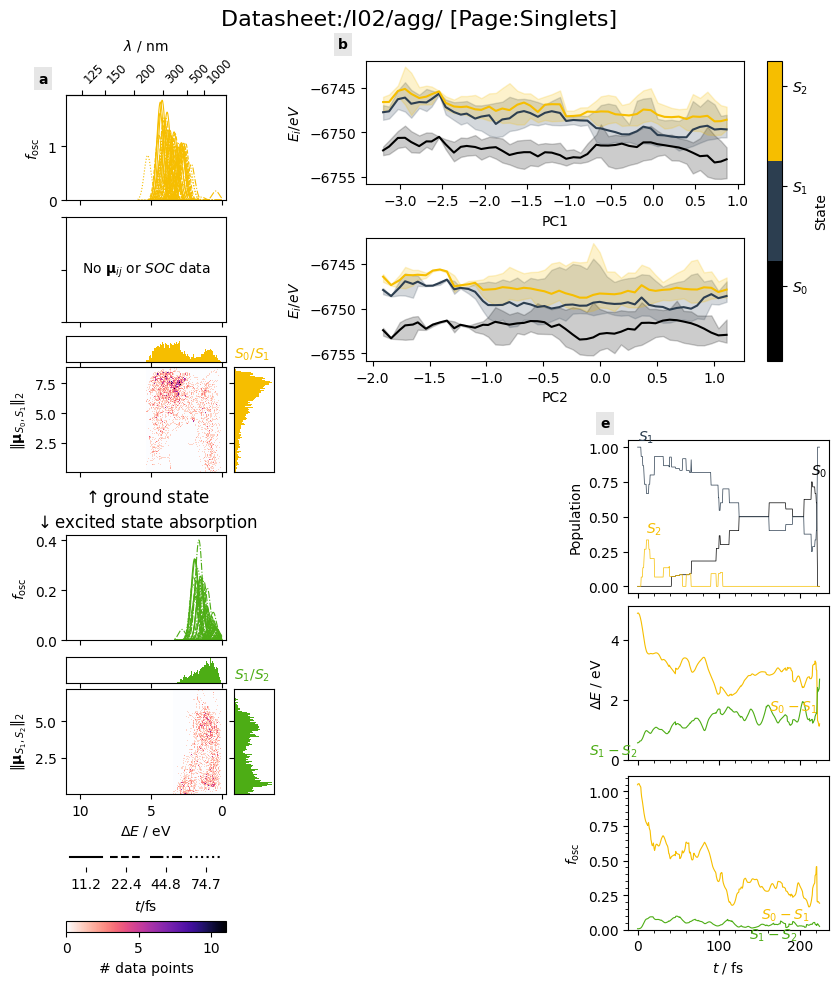

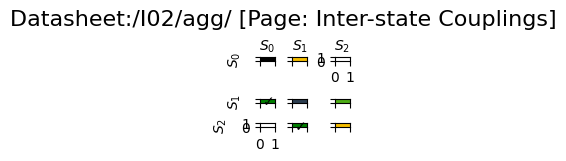

In [21]:
from shnitsel.vis.datasheet import Datasheet

# Initialize the datasheet structures
sheet = Datasheet(truncated_dt, 
                  structure_selection=structure_abd, # Use positions, bond lengths and dihedrals where necessary
                  state_selection="S, 1<>2, 2<>3" # Use all singlet states, transitions between states 1 and 2 as well as between states 2 and 3 but not between 1 and 3.
                  )

# We can also leave out certain pages of the datasheet in the plot outpu, like here, for example, we discard the PCA page and the meta information page bu
# due to the presence of an explicit selection, we will get a `selection` page before singlets.
sheet.plot(include_coupling_page=True, include_pca_page=False, include_meta_page=False, path='./datasheet_states_selected.pdf')
